# Lab 9 Report: 
## Final Project Codebase

## Project Title: Classifying LIGO Signals With CNNs


### Group Members:

Zachary Banken, Nia Marwaha, Alexandre Ramirez

--------------------

### Imports

In [62]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer
import scipy

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

In [63]:
import h5py
filename = "GW2_Andy.h5"
hdf = h5py.File(filename, 'r')
print(list(hdf.keys()))
background=hdf['background']
bbh=hdf['binaryblackhole']
ccsn=hdf['ccsn']
glitch=hdf['glitch']

['background', 'binaryblackhole', 'ccsn', 'glitch']


## Prepare Data

In [64]:
#### Normalize data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Reshape data
bbh = np.array([bbh[:,0], bbh[:,1]])
background = np.array([background[:,0], background[:,1]])
ccsn = np.array([ccsn[:,0], ccsn[:,1]])
glitch = np.array([glitch[:,0], glitch[:,1]])


# print shape
bbh.shape


(2, 2048, 4096)

In [65]:
### Spectrogram function

# create a function that takes in an array of shape (2, 4096) and outputs a spectrogram of shape (2, 128 x 128) using scipy.signal.spectrogram

dt = 0.001

def make_spectrogram (array):
    spec_in = scipy.signal.spectrogram(array, fs=1/dt, nperseg=175, noverlap=120, mode = 'magnitude')
    spec = spec_in[2]
    return spec



In [66]:
### Use function to create spectrograms for all data
### the input data has shape (2, 2048, 4096), and the output data should have shape (2, 2048, x, y) 
### where x and y are the spectrogram dimensions

def convert_data_to_spectrogram (data):
    spectrogram = np.zeros((2, 2048, 88, 72))
    for i in range(2048):
        spectrogram[:,i,:,:] = make_spectrogram(data[:,i,:])
    return spectrogram



In [67]:
### Create spectrograms for all data

bbh_spectrogram = convert_data_to_spectrogram(bbh)
background_spectrogram = convert_data_to_spectrogram(background)
ccsn_spectrogram = convert_data_to_spectrogram(ccsn)
glitch_spectrogram = convert_data_to_spectrogram(glitch)


### Normalize spectrograms

scaler = StandardScaler()

background_spectrogram_norm = scaler.fit_transform(background_spectrogram.reshape(2*2048, 88*72))
bbh_spectrogram_norm = scaler.fit_transform(bbh_spectrogram.reshape(2*2048, 88*72))
ccsn_spectrogram_norm = scaler.fit_transform(ccsn_spectrogram.reshape(2*2048, 88*72))
glitch_spectrogram_norm = scaler.fit_transform(glitch_spectrogram.reshape(2*2048, 88*72))


### Reshape spectrograms

bbh_spectrogram_norm = bbh_spectrogram_norm.reshape(2, 2048, 88, 72)
background_spectrogram_norm = background_spectrogram_norm.reshape(2, 2048, 88, 72)
ccsn_spectrogram_norm = ccsn_spectrogram_norm.reshape(2, 2048, 88, 72)
glitch_spectrogram_norm = glitch_spectrogram_norm.reshape(2, 2048, 88, 72)


### convert above arrays to tensors of the following shape
### (2, 2048, 88, 72) -> (2048, 2, 88, 72) -- (samples, channels, x, y )

bbh_tensor = torch.from_numpy(bbh_spectrogram_norm).permute(1,0,2,3)
background_tensor = torch.from_numpy(background_spectrogram_norm).permute(1,0,2,3)
ccsn_tensor = torch.from_numpy(ccsn_spectrogram_norm).permute(1,0,2,3)
glitch_tensor = torch.from_numpy(glitch_spectrogram_norm).permute(1,0,2,3)


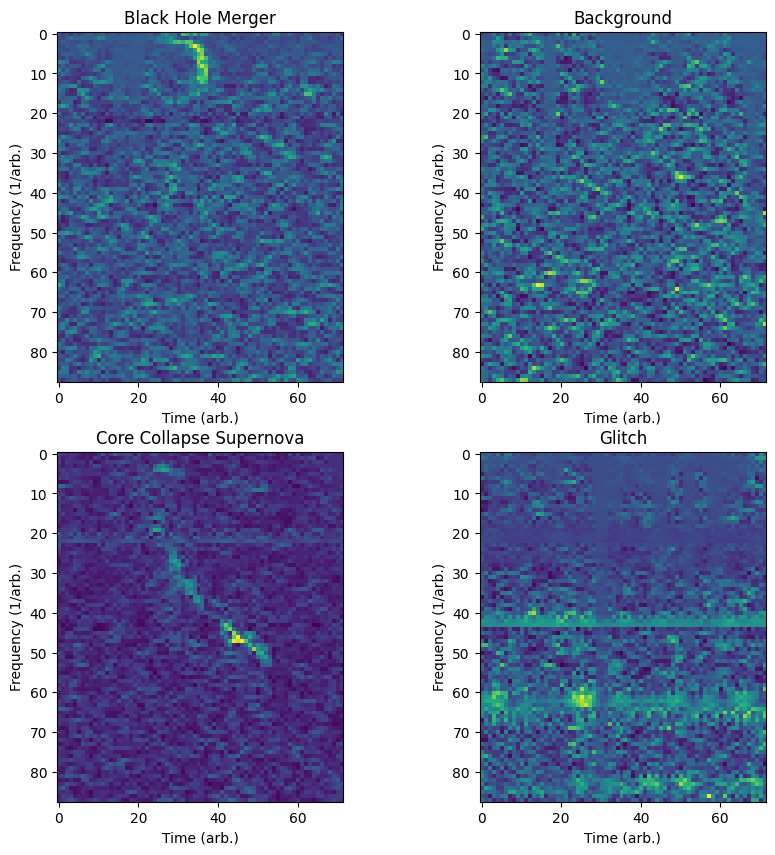

In [68]:
# Show plots of spectrograms for each class in a 2x2 grid using imshow
# use the second index of the tensors as the Red and Blue channels of the image

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].imshow(bbh_tensor[25,0,:,:])
axs[0, 0].set_title('Black Hole Merger')
axs[0, 1].imshow(background_tensor[0,0,:,:])
axs[0, 1].set_title('Background')
axs[1, 0].imshow(ccsn_tensor[0,0,:,:])
axs[1, 0].set_title('Core Collapse Supernova')
axs[1, 1].imshow(glitch_tensor[50,0,:,:])
axs[1, 1].set_title('Glitch')

for ax in axs.flat:
    ax.set(xlabel='Time (arb.)', ylabel='Frequency (1/arb.)')





In [69]:
### randomly split data into training, validation, and test sets

from sklearn.model_selection import train_test_split

bbh_train, bbh_test = train_test_split(bbh_tensor, test_size=0.95, random_state=20, shuffle=True)
bbh_train, bbh_val = train_test_split(bbh_train, test_size=0.2, random_state=20, shuffle=True)

background_train, background_test = train_test_split(background_tensor, test_size=0.95, random_state=20, shuffle=True)
background_train, background_val = train_test_split(background_train, test_size=0.2, random_state=20, shuffle=True)

ccsn_train, ccsn_test = train_test_split(ccsn_tensor, test_size=0.95, random_state=20, shuffle=True)
ccsn_train, ccsn_val = train_test_split(ccsn_train, test_size=0.2, random_state=20, shuffle=True)

glitch_train, glitch_test = train_test_split(glitch_tensor, test_size=0.95, random_state=20, shuffle=True)
glitch_train, glitch_val = train_test_split(glitch_train, test_size=0.2, random_state=20, shuffle=True)

In [70]:
### create labels for data

## 0 -> bbh
## 1 -> background
## 2 -> ccsn
## 3 -> glitch

label_dict = {0:'bbh', 1:'background', 2:'ccsn', 3:'glitch'}

bbh_train_labels = np.zeros(len(bbh_train))
bbh_val_labels = np.zeros(len(bbh_val))
bbh_test_labels = np.zeros(len(bbh_test))

background_train_labels = np.ones(len(background_train))
background_val_labels = np.ones(len(background_val))
background_test_labels = np.ones(len(background_test))

ccsn_train_labels = np.ones(len(ccsn_train))*2
ccsn_val_labels = np.ones(len(ccsn_val))*2
ccsn_test_labels = np.ones(len(ccsn_test))*2

glitch_train_labels = np.ones(len(glitch_train))*3
glitch_val_labels = np.ones(len(glitch_val))*3
glitch_test_labels = np.ones(len(glitch_test))*3


### concatenate data and labels

train_data = torch.cat((bbh_train, background_train, ccsn_train, glitch_train), 0)
train_labels = np.concatenate((bbh_train_labels, background_train_labels, ccsn_train_labels, glitch_train_labels), 0)

val_data = torch.cat((bbh_val, background_val, ccsn_val, glitch_val), 0)
val_labels = np.concatenate((bbh_val_labels, background_val_labels, ccsn_val_labels, glitch_val_labels), 0)

test_data = torch.cat((bbh_test, background_test, ccsn_test, glitch_test), 0)
test_labels = np.concatenate((bbh_test_labels, background_test_labels, ccsn_test_labels, glitch_test_labels), 0)


### shuffle data

from sklearn.utils import shuffle

train_data, train_labels = shuffle(train_data, train_labels,random_state=16)
val_data, val_labels = shuffle(val_data, val_labels, random_state=16)
test_data, test_labels = shuffle(test_data, test_labels, random_state=16)


### create dataloaders

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_data, torch.from_numpy(train_labels))
val_dataset = TensorDataset(val_data, torch.from_numpy(val_labels))
test_dataset = TensorDataset(test_data, torch.from_numpy(test_labels))

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)




In [71]:
### print shapes of training, validation, and test sets

print(bbh_train.shape)
print(bbh_val.shape)
print(bbh_test.shape)

torch.Size([81, 2, 88, 72])
torch.Size([21, 2, 88, 72])
torch.Size([1946, 2, 88, 72])


## Define Model

In [72]:
### Define model using the following architecture
### Layers
### 1. Convolutional layer with 16 filters, kernel size 3, stride 1, padding 1
### Pooling
### Relu
### 2. Convolutional layer with 32 filters, kernel size 3, stride 1, padding 1
### Pooling
### Relu
### 3. Convolutional layer with 64 filters, kernel size 3, stride 1, padding 1
### Pooling
### Relu
### Flatten
### 4. Fully connected layer with 64 neurons
### Relu
### Linear layer to output

## Add batch normalization and dropout to the model
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)

        self.dropout = nn.Dropout(p=0.4)

        self.fc1 = nn.Linear(64*11*9, 64)
        self.fc2 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))

        # flatten 
        
        x = x.view(-1, 64*11*9)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


## Define Hyperparameters

In [73]:
#### Define hyperparameters

epochs = 15
learning_rate = 0.001

### define loss function and optimizer

model = Net()
criterion = nn.CrossEntropyLoss()


step_size = 10
gamma = 0.1


# Initialize the AdamW optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Initialize the StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


model

Net(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=6336, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

## Identify Tracked Values

In [74]:
### tracked values
train_loss_list = []
val_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

## Train Model

In [75]:
### Train the model

for epoch in range(epochs):

    train_loss = 0.0
    val_loss = 0.0
    validation_accuracy = 0.0

    model.train()

    for data, labels in train_dataloader:

        optimizer.zero_grad()

        output = model(data.float())

        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)

    model.eval()

    for data, labels in val_dataloader:

        output = model(data.float())

        _, preds = torch.max(output, 1)

        loss = criterion(output, labels.long())
        val_loss += loss.item()*data.size(0)


    train_loss = train_loss/len(train_dataloader.dataset)
    val_loss = val_loss/len(val_dataloader.dataset)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))

Epoch: 1 	Training Loss: 2.303485 	Validation Loss: 1.365433
Epoch: 2 	Training Loss: 1.260179 	Validation Loss: 1.336482
Epoch: 3 	Training Loss: 1.047094 	Validation Loss: 1.195861
Epoch: 4 	Training Loss: 0.826888 	Validation Loss: 1.043177
Epoch: 5 	Training Loss: 0.666305 	Validation Loss: 0.879073
Epoch: 6 	Training Loss: 0.530187 	Validation Loss: 0.664733
Epoch: 7 	Training Loss: 0.430888 	Validation Loss: 0.445221
Epoch: 8 	Training Loss: 0.358208 	Validation Loss: 0.308003
Epoch: 9 	Training Loss: 0.270712 	Validation Loss: 0.186670
Epoch: 10 	Training Loss: 0.255973 	Validation Loss: 0.124368
Epoch: 11 	Training Loss: 0.191367 	Validation Loss: 0.079565
Epoch: 12 	Training Loss: 0.185055 	Validation Loss: 0.051332
Epoch: 13 	Training Loss: 0.188356 	Validation Loss: 0.036434
Epoch: 14 	Training Loss: 0.172675 	Validation Loss: 0.025641
Epoch: 15 	Training Loss: 0.181053 	Validation Loss: 0.020218


## Visualize & Evaluate Model

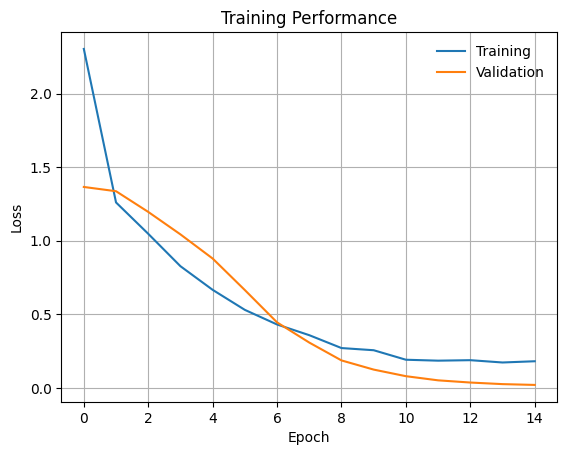

In [76]:
### plot training loss and validation accuracy


plt.plot(train_loss_list, label='Training')
plt.plot(val_loss_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Performance')
plt.grid()
plt.legend(frameon=False)
plt.show()

In [78]:
### Test the model

correct = 0.0

model.eval()

for data, labels in test_dataloader:
    
        ## find predictions
        output = model(data.float())
        _, preds = torch.max(output, 1)
        
        ## add number of correct predictions to total correct
        correct += torch.sum(preds == labels)

## accuracy is number correct divided by total number of predictions
test_accuracy = correct.float()/len(test_dataloader.dataset)

print('Test Accuracy: {:.6f}'.format(test_accuracy))


Test Accuracy: 0.998201
